# Tensorflow 실습 : RNN을 이용한 텍스트 분류

- 학습 속도를 위해, GPU를 사용하기를 권장

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# history를 그래프로 그리기 위해 사용
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## IMDB 데이터셋 

### Setup input pipeline

- IMDB (Internet Movie Database)는 영화 리뷰를 모아 놓은 데이터셋으로, 각 리뷰가 긍정적인지 부정적인지 label이 되어 있음
- 따라서 어떤 리뷰가 긍정/부정적인지 분류하는 binary classification 문제를 학습하기 위해 많이 사용됨
- 또한, text는 대표적인 sequencial data이므로, RNN을 사용해보기에 적합함
- tfds (tensorflow_datasets)를 통해 간단히 load 및 전처리하여 사용 가능

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBY5WP6/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBY5WP6/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteBY5WP6/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


- 데이터셋의 `info`는 encoder를 가지고 있음 (`tfds.features.text.SubwordTextEncoder`)

In [3]:
encoder = info.features['text'].encoder
# 전체 단어의 가지수는 8185
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


- encoder를 이용하면, 영어 문장을 숫자로 표현하고, 숫자를 다시 문장으로 복원하는 것이 가능함
  - encode: 영어 문장 => 정수(integer)의 sequence
  - decode: 정수(integer)의 sequence => 영어 문장

In [4]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [5]:
# 원래 문장과 encode-decode 과정을 통과한 문장은 항상 동일함
assert original_string == sample_string

In [6]:
# 정수 하나와 단어 하나가 매치된 것을 확인할 수 있음
# 완전히 단어 1개 단위로 나뉜 것은 아니고, 음절 단위로 나누는 방식을 활용하는 것으로 보임
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### 참고
- text를 token(정수, integer) 단위로 표현하는 방식은 다양함
- text를 token 단위로 나누어주는 메소드를 Tokenizer라고 함
  - 영어에서 알파벳 하나씩 token 단위로 변환하는 방법 (character level)
  - 음절 단위로 변환
  - 단어 단위로 변환 (word level)
  ---
- 한국어 문장을 이용하기 위해서는 한국어 전용 Tokenizer가 필요함

### 학습을 위한 데이터셋 준비

In [7]:
num_train = len(list(train_dataset))
num_test = len(list(test_dataset))

print('학습 데이터 수: ', num_train)
print('테스트 데이터 수: ', num_test)

BUFFER_SIZE = 10000
BATCH_SIZE = 64

학습 데이터 수:  25000
테스트 데이터 수:  25000


- 테스트 데이터셋은 반으로 나누어서 validation 데이터셋과 테스트 데이터셋으로 사용
  - take: 앞에서부터 인자로 받은 숫자까지의 데이터만 사용
  - skip: 인자로 받은 숫자부터 끝까지 데이터를 사용

In [8]:
valid_dataset = test_dataset.take(num_test // 2)
test_dataset = test_dataset.skip(num_test // 2)

# 학습 시간이 오래걸리므로 학습 데이터를 1/5 만 사용
# 모델의 좋은 성능을 위해서는 학습 데이터를 모두 사용하는 것이 정상적임
train_dataset = train_dataset.take(num_train // 5)

- (중요) 각 리뷰 문장은 token의 개수가 정해져 있는 것이 아니므로, 전체 sequence 길이가 각각 다름
- 따라서 mini batch 안에서 가장 길이가 긴 sequence 길이에 맞도록, 나머지 문장들에 padding token을 추가해줘야 함
  - dataset에서 batch 대신 `padded_batch`를 사용  

padded_batch를 사용하면 가장 길이가 긴 텍스트에 맞춰 padding token이 추가됨


In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

valid_dataset = valid_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

- mini batch load 결과 확인
  - x는 리뷰 데이터, shape는 [batch size, sequence 길이], 가장 길이가 긴 sequence에 맞추어 나머지 문장에는 padding (0)으로 채워짐
  - y는 각 리뷰에 대한 긍정(1), 부정(0) label

In [10]:
for x, y in train_dataset.take(1):
  print(x)
  print(y)

tf.Tensor(
[[5831 1916   90 ...    0    0    0]
 [ 133 3641   95 ...    0    0    0]
 [ 661  290 2002 ...    0    0    0]
 ...
 [ 135 7968    8 ...    0    0    0]
 [  19 6918 7961 ...    0    0    0]
 [  19  480    6 ...    0    0    0]], shape=(64, 1349), dtype=int64)
tf.Tensor(
[0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0
 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0], shape=(64,), dtype=int64)


뒤의 값이 0인 이유는 padded_batch가 되었기 때문이다.

## RNN 모델을 이용한 텍스트 분류

### RNN 모델
- Embedding layer (학습 가능한 파라미터)
  - 정수(integer)를 vector로 mapping하는 방법을 embedding이라고 함
  - 쉽게 이해하자면, 정수 => one-hot vector(8185차원(vocab size)의 벡터로 표현) => W matrix를 곱해주는 것과 동일함 (activation, bias가 없는 Dense layer)
- `tf.keras.layers.Embedding` 사용법
  - input_dim : 전체 vocabulary의 사이즈
  - output_dim : output 벡터의 차원
  - mask_zero : True로 하면, 0의 값(padding)은 mask로 가려지게 됨 
- masking의 의미 : paddding 부분은 RNN 모델에 input으로 사용되지 않고, padding이 아닌부분만 가지고 RNN의 output을 계산함

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=64, mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 561,089
Trainable params: 561,089
Non-trainable params: 0
_________________________________________________________________


### 옵티마이저(optimizer), 손실 함수, 평가 metric 선택

In [12]:
# Binary classification에 적합한 loss를 선정, 마지막 dense layer에 sigmoid activation이 없으므로 from_logits=True
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

###모델 학습


In [13]:
# 한 epoch에 걸리는 시간을 줄이기 위해, validation step을 30으로 제한
history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    validation_steps=30)

Epoch 1/10
79/79 [==============================] - 17s 92ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6928 - val_accuracy: 0.4917
Epoch 2/10
79/79 [==============================] - 6s 74ms/step - loss: 0.6921 - accuracy: 0.4921 - val_loss: 0.6918 - val_accuracy: 0.4917
Epoch 3/10
79/79 [==============================] - 6s 73ms/step - loss: 0.6887 - accuracy: 0.4916 - val_loss: 0.6734 - val_accuracy: 0.4948
Epoch 4/10
79/79 [==============================] - 6s 74ms/step - loss: 0.6579 - accuracy: 0.5239 - val_loss: 0.6396 - val_accuracy: 0.7495
Epoch 5/10
79/79 [==============================] - 6s 73ms/step - loss: 0.5693 - accuracy: 0.7135 - val_loss: 0.5388 - val_accuracy: 0.7708
Epoch 6/10
79/79 [==============================] - 6s 74ms/step - loss: 0.4141 - accuracy: 0.8457 - val_loss: 0.4302 - val_accuracy: 0.8109
Epoch 7/10
79/79 [==============================] - 6s 73ms/step - loss: 0.2706 - accuracy: 0.9024 - val_loss: 0.3937 - val_accuracy: 0.8234
Epoch 8/10
7

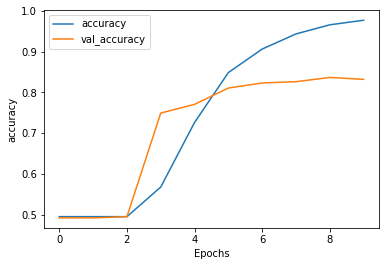

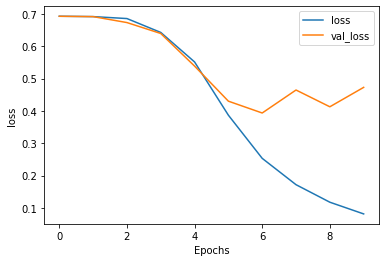

In [14]:
# 그래프 그리기
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### 모델 평가

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

196/196 [==============================] - 6s 29ms/step - loss: 0.4554 - accuracy: 0.8366
Test Loss: 0.4553927779197693
Test Accuracy: 0.8366400003433228


### 학습된 모델 활용

In [16]:
# predict on a sample text
sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'

# 정수(integer) sequence로 encode
sample_input = encoder.encode(sample_text)

# 모델의 input으로 넣어주기 위해, batch 축 추가
sample_input = tf.expand_dims(sample_input, axis=0)

# 학습된 모델로 긍정/부정 예측
prediction = model(sample_input)

# 마지막 sigmoid activation이 없으므로, output logit 값이 양수이면 긍정적, 음수이면 부정적임을 의미함
print(prediction)


tf.Tensor([[-0.26530147]], shape=(1, 1), dtype=float32)


- 다음 문제 실습을 위해, 학습된 모델 삭제

In [17]:
del model

## RNN 실습
데이터셋은 그대로 이용하고 나머지 부분을 직접 구현해보기

### 문제 1: RNN 모델 만들기
- 조건: 딥러닝 모델의 각 layer는 1번부터 8번까지 순서대로 구성
1. embedding layer, input_dim: vocab size, output_dim: 128, mask zero: True
2. bidirectional, GRU layer, hidden units 64 (Hint: RNN layer를 여러개 쌓는 상황을 고려해야 함)
3. layer normalization
4. GRU layer, hidden units 32
5. layer normalization
6. dropout layer, probability 0.2
7. dense layer, hidden node 32, ReLU activation
8. dense layer, hidden node 1
- 딥러닝 모델을 만드는 두가지 방식(tf.keras.Model, tf.keras.models.Sequential) 중 선택하여 만들기

In [18]:
# 여기에 문제 1에 대한 코드를 작성하면 됩니다.
# Batch Normalization보다 Layer Normalization이 RNN과 잘 어울린다.

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=128, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
                             tf.keras.layers.LayerNormalization(),
                             tf.keras.layers.GRU(32),
                             tf.keras.layers.LayerNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1047680   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         74496     
_________________________________________________________________
layer_normalization (LayerNo (None, None, 128)         256       
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                15552     
_________________________________________________________________
layer_normalization_1 (Layer (None, 32)                64        
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

### 문제 2: 옵티마이저(optimizer), 손실 함수, 평가 metric 선택
- 조건1: model.compile로 지정
- 조건2: binary classification에 적합한 loss 선택, from logits: True
- 조건3: Adam optimizer, learning rate: 0.001
- 조건4: metric은 accuracy

In [19]:
# 여기에 문제 2에 대한 코드를 작성하면 됩니다.

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

### 문제 3: 모델 학습 및 평가
- 조건1: model.fit으로 학습
- 조건2: 5 epoch 동안 학습
- 조건3: 학습 데이터로 `train_dataset` 이용
- 조건4: `valid_dataset`으로 validation, 매번 epoch 당 validation step은 20번
- 조건5: 학습이 완료된 모델을 이용하여, `test_dataset`으로 모델 평가

In [20]:
# 여기에 문제 3에 대한 코드를 작성하면 됩니다.

history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    validation_steps=20)

Epoch 1/10
79/79 [==============================] - 26s 218ms/step - loss: 0.7206 - accuracy: 0.5123 - val_loss: 0.6562 - val_accuracy: 0.6031
Epoch 2/10
79/79 [==============================] - 15s 182ms/step - loss: 0.5024 - accuracy: 0.7605 - val_loss: 0.6012 - val_accuracy: 0.7016
Epoch 3/10
79/79 [==============================] - 15s 182ms/step - loss: 0.2352 - accuracy: 0.9061 - val_loss: 0.7150 - val_accuracy: 0.7008
Epoch 4/10
79/79 [==============================] - 15s 185ms/step - loss: 0.0953 - accuracy: 0.9658 - val_loss: 0.9071 - val_accuracy: 0.7000
Epoch 5/10
79/79 [==============================] - 15s 185ms/step - loss: 0.0352 - accuracy: 0.9904 - val_loss: 1.0631 - val_accuracy: 0.7125
Epoch 6/10
79/79 [==============================] - 15s 183ms/step - loss: 0.0289 - accuracy: 0.9892 - val_loss: 1.3483 - val_accuracy: 0.7141
Epoch 7/10
79/79 [==============================] - 15s 186ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 1.5227 - val_accuracy: 0.6914

train accuracy는 0.99인 반면에 val accuracy는 0.67로 차이가 많이나 Overfitting이 발생한 것으로 알 수 있다.
이 경우는 모델의 복잡도가 높은 경우에 발생한다. 이는 모델이 굉장히 견고해서 모든 데이터를 다 학습해 overfitting이 발생한 것으로 알 수 있다.

In [21]:
# testdataset으로 모델 평가
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {:.3f}'.format(test_loss))
print('Test Accuracy: {:.3f}'.format(test_acc))

196/196 [==============================] - 16s 78ms/step - loss: 1.4564 - accuracy: 0.7177
Test Loss: 1.456
Test Accuracy: 0.718


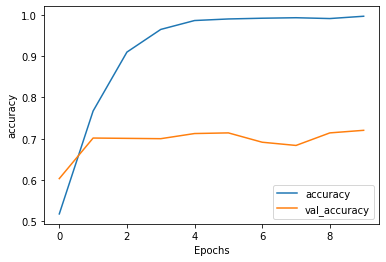

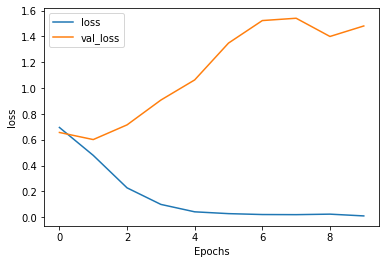

In [22]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### 문제 4: 학습된 모델 활용

- 가상의 리뷰를 직접 작성하여 모델의 input으로 넣어보기
- 조건: 긍적적인 리뷰 1개와 부정적인 리뷰 1개를 작성하여, 모델의 예측값을 확인해보기

In [23]:
# 여기에 문제 4에 대한 코드를 작성하면 됩니다.

sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie. good good good'
sample_input = encoder.encode(sample_text)
sample_input = tf.expand_dims(sample_input, axis=0)
prediction = model(sample_input)
print(prediction)


tf.Tensor([[2.8884177]], shape=(1, 1), dtype=float32)


In [24]:
sample_text = 'This movie is ambiguous. There was also an interesting part, but most of the time was boring. bad bad bad'
sample_input = encoder.encode(sample_text)
sample_input = tf.expand_dims(sample_input, axis=0)
prediction = model(sample_input)
print(prediction)

tf.Tensor([[-6.722139]], shape=(1, 1), dtype=float32)


- (참고) 학습 데이터를 많이 사용하면, 오버피팅이 어느정도 해결되고 더 나은 성능을 보인다는 것을 확인할 수 있음